# Option Pricing Under Fat Tails with PyMC
Our objective is to explore and understand the tail option pricing formula in [Tail Option Pricing Under Power Laws](https://arxiv.org/abs/1908.02347) (Taleb et. al. 2019) and [The Statistical Consequences of Fat Tails](https://arxiv.org/abs/2001.10488) (Taleb, 2020). This notebook has a few objectives:



*   Provide a reference for how to fetch current option chains and historical stock data.
*   Provide a reference for analyzing stock returns using PyMC for Markov Chain Monte Carlo.
* Provide a reference implementation of the pricing functions in The Statistical Consequences of Fat Tails.
* Visualize the results of the analysis to provide an intuition of fit and results.

### Future Work


*   I'd love to add a more sophisticated analysis with PyMC where we calibrate to the existing option chain rather than the historical returns distribution.
*   Convenience functions to handle the dte/period selection for the user.
* Implement a check to satisfy the arbitrage boundaries outlined in the paper.





In [162]:
import pandas as pd
import numpy as np
import urllib.request, json
import datetime
import scipy.stats as st
import pymc as pm
import arviz as az
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

pd.options.mode.copy_on_write = True

In [143]:
# Parameters
target_dte = 1.  # Days to expiry on the option chain, should coincide with period below.
period = "1d";   # Period for yfinance. 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max. Should match the target dte!
ticker = "AAPL"   # Ticker on which we should fetch underlying history and options chain.
mad_distance = 2  # Mean absolute deviations to consider the start of the tail

# Aliases for use with the CBOE API.
ticker_alias = {
    "^SPX": "_SPX",
    "^XSP": "_XSP"
}

## Fetch Option Chain
CBOE provides 15 minute delayed data. We'll fetch one of these chains to provide us with some working data. A lot of the data we want is encoded in the option symbol which is a great shorthand but we'll create some enrichment functions to extract this data.

In [144]:
with urllib.request.urlopen("https://cdn.cboe.com/api/global/delayed_quotes/options/" + ticker_alias.get(ticker, ticker) + ".json") as url:
    raw_chain = json.load(url)
    all_chains = pd.json_normalize(raw_chain, record_path=['data', 'options'])
    spot = raw_chain['data']['current_price']

# Enrichment functions for the option chains to make them more amenable to querying.

# Symbols are SPXYYMMDDC00100000
# The strike is the last 8 digits, must be divided by 10000
# Indexing from the back makes these functions robust to varying length tickers

def symbol_to_ticker(symbol: str) -> str:
  return symbol[:-15]
def symbol_to_date(symbol: str) -> str:
  return symbol[-15:-9]
def symbol_to_type(symbol: str) -> str:
  return symbol[-9]
def symbol_to_strike(symbol: str) -> float:
  return int(symbol[-8:])/1000
def symbol_to_year(symbol: str) -> int:
  return int(symbol[-15:-13]) + 2000
def symbol_to_month(symbol: str) -> int:
  return int(symbol[-13:-11])
def symbol_to_day(symbol: str) -> int:
  return int(symbol[-11:-9])
def symbol_to_dte(symbol: str) -> int:
  return (datetime.date(symbol_to_year(symbol), symbol_to_month(symbol), symbol_to_day(symbol)) - datetime.date.today()).days

# Perform Option Chain Enrichment
all_chains['type'] = all_chains['option'].apply(symbol_to_type)
all_chains['year'] = all_chains['option'].apply(symbol_to_year)
all_chains['month'] = all_chains['option'].apply(symbol_to_month)
all_chains['day'] = all_chains['option'].apply(symbol_to_day)
all_chains['strike'] = all_chains['option'].apply(symbol_to_strike)
all_chains['ticker'] = all_chains['option'].apply(symbol_to_ticker)
all_chains['dte'] = all_chains['option'].apply(symbol_to_dte)

# Filter to our target DTE.
chain = all_chains[all_chains['dte'] == target_dte]
chain.head()[['option', 'ticker', 'strike', 'type', 'dte']]

,option,ticker,strike,type,dte
0,AAPL250516C00095000,AAPL,95.0,C,1
1,AAPL250516P00095000,AAPL,95.0,P,1
2,AAPL250516C00100000,AAPL,100.0,C,1
3,AAPL250516P00100000,AAPL,100.0,P,1
4,AAPL250516C00105000,AAPL,105.0,C,1


# Calibrating α on Returns Data
We use close to close as our return measurement primarily because Yahoo Finance doesn't provide OLHC data until ~1983 which is less history than we'd like when calculating the parameters for the distribution. Our objective is to calibrate our `α` on the historical returns of the SPX.

In [145]:
history = yf.download("^SPX", start="1950-01-01", end="2025-05-14")

[*********************100%***********************]  1 of 1 completed


In [146]:
def shift(arr, num, fill_value=np.nan):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

data = history.copy(True)
data['close_to_close', '^SPX'] = data['Close'].diff()
close = data['Close', '^SPX'].to_numpy()
shifted_close = shift(close, 1)
returns = close/shifted_close
returns = returns[~np.isnan(returns)]
log_returns = np.log(returns) # Just for interest, not actually using this at the moment.

In [147]:
def npmad(xs):
  return np.mean(np.absolute(xs - xs.mean()))

mad = npmad(returns)
mu = returns.mean()

right_tail_start = mu + mad_distance * mad
left_tail_start = mu - mad_distance * mad
right_tail_returns = returns[returns > right_tail_start] - 1
left_tail_returns = returns[returns < left_tail_start] - 1

right_tail_returns = right_tail_returns[~np.isnan(right_tail_returns)]
left_tail_returns = left_tail_returns[~np.isnan(left_tail_returns)] * -1.0 # Map left tail returns to positive domain for modeling with a Pareto.

## Modeling with PyMC
We'll set up a basic Bayesian model where we condition two likelihoods on each tail. We're trying to determine the `α` value governing the tail behavior. Ideally in a future iteration I'd enhance this model to calibrate alpha against
the option chain as well.

Output()

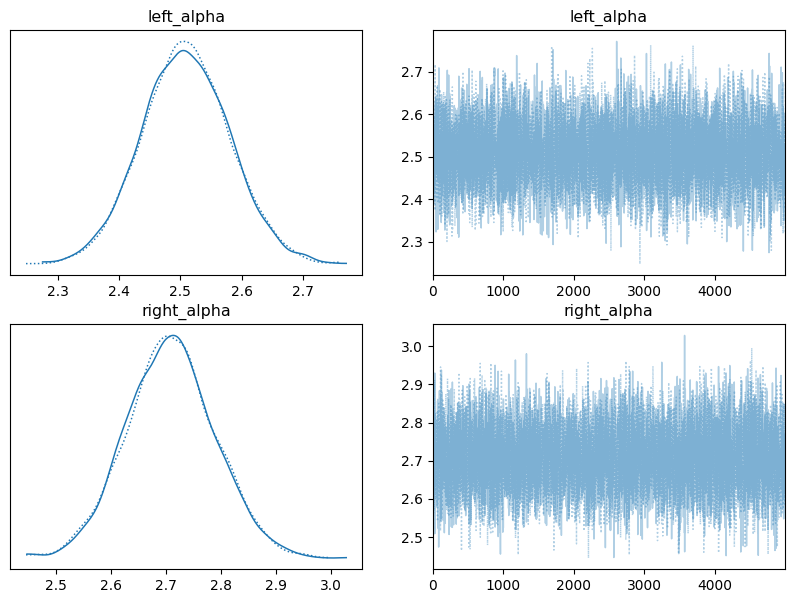

In [148]:
with pm.Model() as model:
  right_alpha = pm.Uniform('right_alpha', lower=0.75, upper=5)
  left_alpha = pm.Uniform('left_alpha', lower=0.75, upper=5)

  right_likelihood = pm.Pareto('right_likelihood', m=right_tail_returns.min(),
                               alpha=right_alpha, observed=right_tail_returns)
  left_likelihood = pm.Pareto('left_likelihood', m=left_tail_returns.min(),
                              alpha=left_alpha, observed=left_tail_returns)
  idata = pm.sample(5000)

  az.plot_trace(idata, figsize=(10, 7));

right_alpha = idata.posterior['right_alpha'].values.mean()
left_alpha = idata.posterior['left_alpha'].values.mean()

## Pricing The Tails



In [149]:
def put_price(K2, K1, S0, P1, a):
  """
  Compute the put price for K2 under fat tails calibrated to `\alpha` and
  anchored on the option struck at K1 with price P1.

  This is the version of the function presented in the first version of
  Tail Option Pricing Under Power Laws in 2019. It appears to have less issues
  with lower alpha values.

  Parameters
  ----------
  K2 : Float or Integer representing the strike price of the option under pricing.
  K1 : Float or Integer representing the strike price of the anchor option.
  S0 : Spot price of the asset under pricing.
  P1 : Market price for the option struck at K1.
  a  : Alpha value governing the fat tails.

  Returns
  -------
  A float representing the theoretical price for the option struck at K2. This
  function truncates the result to the real line.
  """
  K2 = float(K2)
  K1 = float(K1)
  S0 = float(S0)
  P1 = float(P1)
  a = float(a)
  numerator =   (S0 ** -a * ((a - 1) * K2 + S0) - (K2 - S0) ** (1 - a))
  #   ------------------------------------------------------------
  denominator = (S0 ** -a * ((a - 1) * K1 + S0) - (K1 - S0) ** (1 - a))
  return (P1 * (numerator / denominator)).real

def put_price_2(K2, K1, S0, P1, a):
  """
  Compute the put price for K2 under fat tails calibrated to `\alpha` and
  anchored on the option struck at K1 with price P1.

  Note: This is from v2/v3 of Tail Option Pricing Under Power Laws / The]
  Statistical Consequences of Fat Tails. It appears to generate nonsensical
  values if `\alpha` is low enough. For example options further out of the money
  can have a higher price, violating arbitrage boundaries.

  Parameters
  ----------
  K2 : Float or Integer representing the strike price of the option under pricing.
  K1 : Float or Integer representing the strike price of the anchor option.
  S0 : Spot price of the asset under pricing.
  P1 : Market price for the option struck at K1.
  a  : Alpha value governing the fat tails.

  Returns
  -------
  A float representing the theoretical price for the option struck at K2. This
  function truncates the result to the real line.
  """
  K2 = float(K2)
  K1 = float(K1)
  S0 = float(S0)
  P1 = float(P1)
  a = float(a)
  numerator =   (K2 - S0)**(1-a) - S0**(1-a) * ((-(1-a))*K2 + S0)
  #   ------------------------------------------------------------
  denominator = (K1 - S0)**(1-a) - S0**(1-a) * ((-(1-a))*K1 + S0)
  return (numerator / denominator * P1).real

def call_price(K2, K1, S0, C1, a):
  """
  Compute the call price for K2 under fat tails calibrated to `\alpha` and
  anchored on the option struck at K1 with price C1.

  Parameters
  ----------
  K2 : Float or Integer representing the strike price of the option under pricing.
  K1 : Float or Integer representing the strike price of the anchor option.
  S0 : Spot price of the asset under pricing.
  C1 : Market price for the option struck at K1.
  a  : Alpha value governing the fat tails.

  Returns
  -------
  A float representing the theoretical price for the option struck at K2.
  """
  K2 = float(K2)
  K1 = float(K1)
  S0 = float(S0)
  C1 = float(C1)
  a = float(a)
  return C1 * ( (K2 - S0) / (K1 - S0) ) ** (1 - a)

In [152]:
# Identify and tag the closest strike to our tail starts
calls = chain.query('`type` == "C"')
puts = chain.query('`type` == "P"')
right_tail_anchor_option = calls.loc[(calls['strike'] - (spot * right_tail_start)).abs().idxmin()]
left_tail_anchor_option = puts.loc[(puts['strike'] - (spot * left_tail_start)).abs().idxmin()]
right_tail_strike = right_tail_anchor_option['strike']
left_tail_strike = left_tail_anchor_option['strike']

query_ticker = ticker.replace("^", "").replace("_", "")

# Separate out the tails
right_tail = chain.query('strike > @right_tail_strike and `type` == "C" and ticker == @query_ticker')
left_tail = chain.query('strike < @left_tail_strike and `type` == "P" and ticker == @query_ticker')

# Define some partially applied functions to make use a little easier.
from functools import partial
call_price_partial = partial(call_price, K1=right_tail_anchor_option['strike'],
                             S0=spot,
                             C1=(right_tail_anchor_option['bid'] \
                                 + right_tail_anchor_option['bid']) / 2.0,
                             a=right_alpha)
v_call_price_partial = np.vectorize(call_price_partial)

put_price_partial = partial(put_price,
                            K1=left_tail_anchor_option['strike'],
                            S0=spot,
                            P1=(left_tail_anchor_option['bid'] \
                                + left_tail_anchor_option['ask']) / 2.0,
                             a=left_alpha)
v_put_price_partial = np.vectorize(put_price_partial)

# Perform the pricing
right_tail['fat_tail_theo'] = right_tail['strike'].apply(call_price_partial)
left_tail['fat_tail_theo'] = left_tail['strike'].apply(put_price_partial)

## Visualize Results
We'll visualize the results as a quick sanity check and to provide us with some intuition about how the option prices on the chain might differ from our expectations calibrated on historical stock performance.

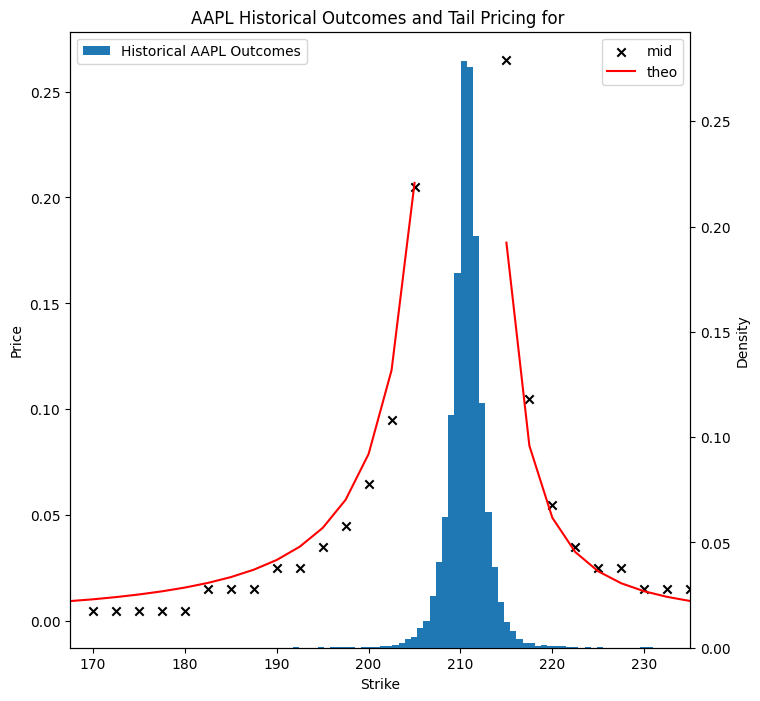

In [161]:
right_tail_x = np.linspace(right_tail_start-1, returns.max()-1, 1000)
right_tail_dist = pm.Pareto.dist(alpha=right_alpha, m=right_tail_start-1)

right_tail_y = np.exp(pm.logp(right_tail_dist, right_tail_x).eval())
right_tail_mid = (right_tail['bid'] + right_tail['ask']) / 2.0

# Left tail needs to be mapped to positive domain then flipped back for viz
left_tail_x = (1 - np.linspace(returns.min(), left_tail_start, 1000))
left_tail_y = np.exp(pm.logp(pm.Pareto.dist(alpha=left_alpha, m=left_tail_start), left_tail_x).eval())
left_tail_mid = (left_tail['bid'] + left_tail['ask']) / 2.0

fig, ax1 = plt.subplots(figsize=(8, 8))
#n, bins, patches = plt.hist(returns, bins=100, density=True, stacked=True)
ax1.scatter(right_tail['strike'].to_numpy(), right_tail_mid, marker='x', color='black', label="mid")
ax1.scatter(left_tail['strike'].to_numpy(), left_tail_mid, marker='x', color='black')
ax1.plot(right_tail['strike'].to_numpy(), right_tail['fat_tail_theo'], label="theo", color="red")
ax1.plot(left_tail['strike'].to_numpy(), left_tail['fat_tail_theo'], color="red")

ax1.set_xlabel("Strike")
ax1.set_ylabel("Price")
ax1.legend()

ax2 = ax1.twinx()
ax2.hist(returns * spot, bins=100, density=True, label="Historical " + ticker + " Outcomes")
ax2.set_ylabel("Density")
ax2.legend(loc="upper left")

plt.title(ticker + " Historical Outcomes and Tail Pricing for " + )

plt.xlim(spot * returns.min(), spot * returns.max())
plt.show()